
⚖️ GENDER FAIRNESS ANALYSIS

[1/3] Loading data...
✓ Loaded: 20,993 patients
✓ Gender distribution:
Male      13661
Female     7332
Name: Sex, dtype: int64

[2/3] Calculating fairness metrics...
  Female: n=7,332 | Sens= 80.4% | FNR= 19.6% | FPR= 36.9%
  Male  : n=13,661 | Sens= 80.3% | FNR= 19.7% | FPR= 36.2%

[3/3] Creating visualization...

✅ Saved: p:\projects\heart_disease_prediction\reports\modeling\rai reports\01_gender_fairness.png


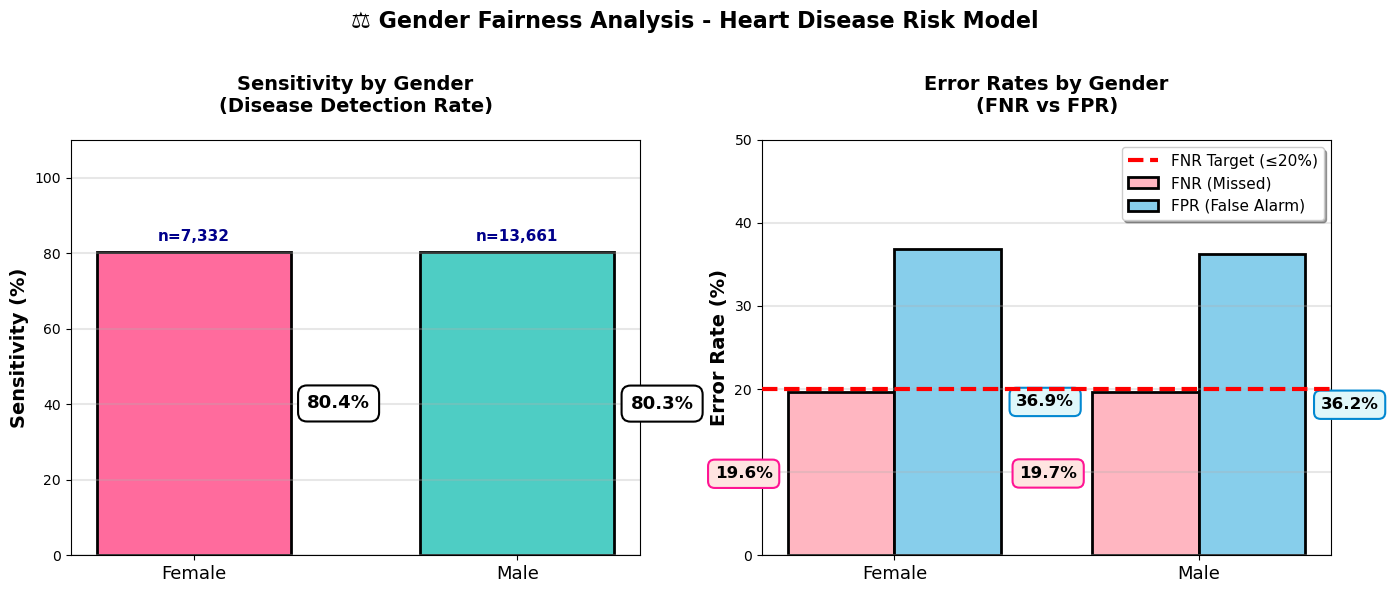


GENDER FAIRNESS METRICS
   Sex  Sample  Disease_Rate  Sensitivity       FNR       FPR
Female    7332     50.627387    80.387931 19.612069 36.906077
  Male   13661     49.630335    80.309735 19.690265 36.230199

📊 Fairness Assessment:
   FNR Difference: 0.08%
   Sensitivity Difference: 0.08%
   Status: ✅ PASS (FNR gap < 5%)



In [3]:
"""
RAI ANALYSIS #1: GENDER FAIRNESS
Analyzes model fairness between Female and Male patients
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import confusion_matrix

# ============================================================================
# SETUP
# ============================================================================
PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts'
DATA_DIR = ARTIFACTS_DIR / 'split data sets'
REPORTS_DIR = PROJECT_ROOT / 'reports' / 'modeling'
METRICS_DIR = REPORTS_DIR / 'metrics'
FIGURES_DIR = REPORTS_DIR / 'rai reports'
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

RANDOM_STATE = 42

print("\n" + "="*80)
print("⚖️ GENDER FAIRNESS ANALYSIS")
print("="*80)

# ============================================================================
# LOAD DATA
# ============================================================================
print("\n[1/3] Loading data...")

# Load risk profiles
df_risk_profiles = pd.read_parquet(METRICS_DIR / 'df_risk_profiles.parquet')

# Load test data to get Sex
X_test_full = pd.read_parquet(DATA_DIR / 'X_test.parquet')

# Merge demographics
X_test_indexed = X_test_full.reset_index(drop=True)
X_test_indexed['Patient_Index'] = X_test_indexed.index
df_demographics = X_test_indexed[['Patient_Index', 'Sex']].copy()

df_test = df_risk_profiles.merge(df_demographics, on='Patient_Index', how='left')

# ✅ Correct Sex encoding (0=Female, 1=Male)
df_test['Sex'] = df_test['Sex'].map({0: 'Female', 1: 'Male'})

print(f"✓ Loaded: {len(df_test):,} patients")
print(f"✓ Gender distribution:")
print(df_test['Sex'].value_counts())

# ============================================================================
# CALCULATE METRICS
# ============================================================================
print("\n[2/3] Calculating fairness metrics...")

metrics = []
for sex in ['Female', 'Male']:
    mask = df_test['Sex'] == sex
    
    if mask.sum() == 0:
        print(f"⚠️  No {sex} patients found!")
        continue
    
    y_true = df_test[mask]['Actual_Disease'].values
    y_pred = df_test[mask]['Predicted_Disease'].values
    
    # Handle edge cases
    if len(np.unique(y_true)) < 2 or len(np.unique(y_pred)) < 2:
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        if cm.size == 4:
            tn, fp, fn, tp = cm.ravel()
        else:
            tn, fp, fn, tp = 0, 0, 0, 0
    else:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    sensitivity = (tp / (tp + fn) * 100) if (tp + fn) > 0 else 0
    fnr = (fn / (tp + fn) * 100) if (tp + fn) > 0 else 0
    fpr = (fp / (fp + tn) * 100) if (fp + tn) > 0 else 0
    
    metrics.append({
        'Sex': sex,
        'Sensitivity': sensitivity,
        'FNR': fnr,
        'FPR': fpr,
        'Sample': int(mask.sum()),
        'Disease_Count': int(y_true.sum()),
        'Disease_Rate': float(y_true.mean() * 100),
        'TP': int(tp),
        'FP': int(fp),
        'TN': int(tn),
        'FN': int(fn)
    })
    
    print(f"  {sex:6s}: n={mask.sum():5,} | Sens={sensitivity:5.1f}% | FNR={fnr:5.1f}% | FPR={fpr:5.1f}%")

df_metrics = pd.DataFrame(metrics)

# ============================================================================
# CREATE VISUALIZATION
# ============================================================================
print("\n[3/3] Creating visualization...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('⚖️ Gender Fairness Analysis - Heart Disease Risk Model', 
             fontsize=16, fontweight='bold', y=0.98)

# ============================================
# LEFT: Sensitivity Comparison
# ============================================
x = np.arange(len(df_metrics))
width = 0.6

sensitivity_vals = df_metrics['Sensitivity'].values

bars = ax1.bar(x, sensitivity_vals, width, 
               color=['#FF6B9D', '#4ECDC4'], 
               edgecolor='black', linewidth=2)

ax1.set_ylabel('Sensitivity (%)', fontsize=14, fontweight='bold')
ax1.set_title('Sensitivity by Gender\n(Disease Detection Rate)', 
              fontsize=14, fontweight='bold', pad=20)
ax1.set_xticks(x)
ax1.set_xticklabels(df_metrics['Sex'].values, fontsize=13)
ax1.set_ylim([0, 110])
ax1.grid(alpha=0.3, axis='y', linewidth=1.5)

# Add labels to the right side of bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    # Main value label
    ax1.text(bar.get_x() + bar.get_width() + 0.05, height/2,
            f'{height:.1f}%',
            ha='left', va='center', fontweight='bold', fontsize=13,
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                     edgecolor='black', linewidth=1.5))
    
    # Sample size label above
    ax1.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'n={df_metrics.iloc[i]["Sample"]:,}',
            ha='center', va='bottom', fontweight='bold', fontsize=11,
            color='darkblue')

# ============================================
# RIGHT: Error Rates Comparison
# ============================================
x = np.arange(len(df_metrics))
width = 0.35

fnr_vals = df_metrics['FNR'].values
fpr_vals = df_metrics['FPR'].values

bars1 = ax2.bar(x - width/2, fnr_vals, width, label='FNR (Missed)', 
                color='#FFB6C1', edgecolor='black', linewidth=2)
bars2 = ax2.bar(x + width/2, fpr_vals, width, label='FPR (False Alarm)', 
                color='#87CEEB', edgecolor='black', linewidth=2)

ax2.axhline(y=20, color='red', linestyle='--', linewidth=3, 
            label='FNR Target (≤20%)', zorder=5)

ax2.set_ylabel('Error Rate (%)', fontsize=14, fontweight='bold')
ax2.set_title('Error Rates by Gender\n(FNR vs FPR)', 
              fontsize=14, fontweight='bold', pad=20)
ax2.set_xticks(x)
ax2.set_xticklabels(df_metrics['Sex'].values, fontsize=13)
ax2.set_ylim([0, 50])
ax2.legend(fontsize=11, frameon=True, shadow=True, loc='upper right')
ax2.grid(alpha=0.3, axis='y', linewidth=1.5)

# Add labels to sides
for i, bar in enumerate(bars1):
    height = bar.get_height()
    if height > 0:
        # FNR label to LEFT
        ax2.text(bar.get_x() - 0.05, height/2,
                f'{height:.1f}%',
                ha='right', va='center', fontweight='bold', fontsize=12,
                bbox=dict(boxstyle='round,pad=0.4', facecolor='#FFE4E1', 
                         edgecolor='#FF1493', linewidth=1.5))

for i, bar in enumerate(bars2):
    height = bar.get_height()
    if height > 0:
        # FPR label to RIGHT
        ax2.text(bar.get_x() + bar.get_width() + 0.05, height/2,
                f'{height:.1f}%',
                ha='left', va='center', fontweight='bold', fontsize=12,
                bbox=dict(boxstyle='round,pad=0.4', facecolor='#E0F7FA', 
                         edgecolor='#0288D1', linewidth=1.5))

plt.tight_layout(rect=[0, 0, 1, 0.96])

# ============================================================================
# SAVE
# ============================================================================
output_path = FIGURES_DIR / '01_gender_fairness.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\n✅ Saved: {output_path}")
plt.show()
plt.close()

# ============================================================================
# FAIRNESS ASSESSMENT
# ============================================================================
print("\n" + "="*80)
print("GENDER FAIRNESS METRICS")
print("="*80)
print(df_metrics[['Sex', 'Sample', 'Disease_Rate', 'Sensitivity', 'FNR', 'FPR']].to_string(index=False))

if len(df_metrics) == 2:
    fnr_diff = abs(df_metrics['FNR'].iloc[0] - df_metrics['FNR'].iloc[1])
    sens_diff = abs(df_metrics['Sensitivity'].iloc[0] - df_metrics['Sensitivity'].iloc[1])
    
    print(f"\n📊 Fairness Assessment:")
    print(f"   FNR Difference: {fnr_diff:.2f}%")
    print(f"   Sensitivity Difference: {sens_diff:.2f}%")
    
    if fnr_diff < 5:
        print(f"   Status: ✅ PASS (FNR gap < 5%)")
    else:
        print(f"   Status: ⚠️ NEEDS REVIEW (FNR gap ≥ 5%)")
else:
    print("\n⚠️  Insufficient gender groups for comparison")

print("="*80 + "\n")



⚖️ AGE GROUP FAIRNESS ANALYSIS

[1/3] Loading data...
✓ Loaded: 20,993 patients
✓ Age range: 39.1 - 64.9 years

[2/3] Creating age groups...
✓ Age group distribution:
  Young (≤45)         : 3,120 ( 14.9%)
  Middle (46-60)      : 14,061 ( 67.0%)
  Elderly (61+)       : 3,812 ( 18.2%)

[3/3] Calculating fairness metrics...
  Young (≤45)         : n=3,120 | Sens= 62.8% | FNR= 37.2% | FPR=  9.3%
  Middle (46-60)      : n=14,061 | Sens= 76.4% | FNR= 23.6% | FPR= 35.5%
  Elderly (61+)       : n=3,812 | Sens= 97.6% | FNR=  2.4% | FPR= 88.9%

Creating visualization...

✅ Saved: p:\projects\heart_disease_prediction\reports\modeling\rai reports\02_age_fairness.png


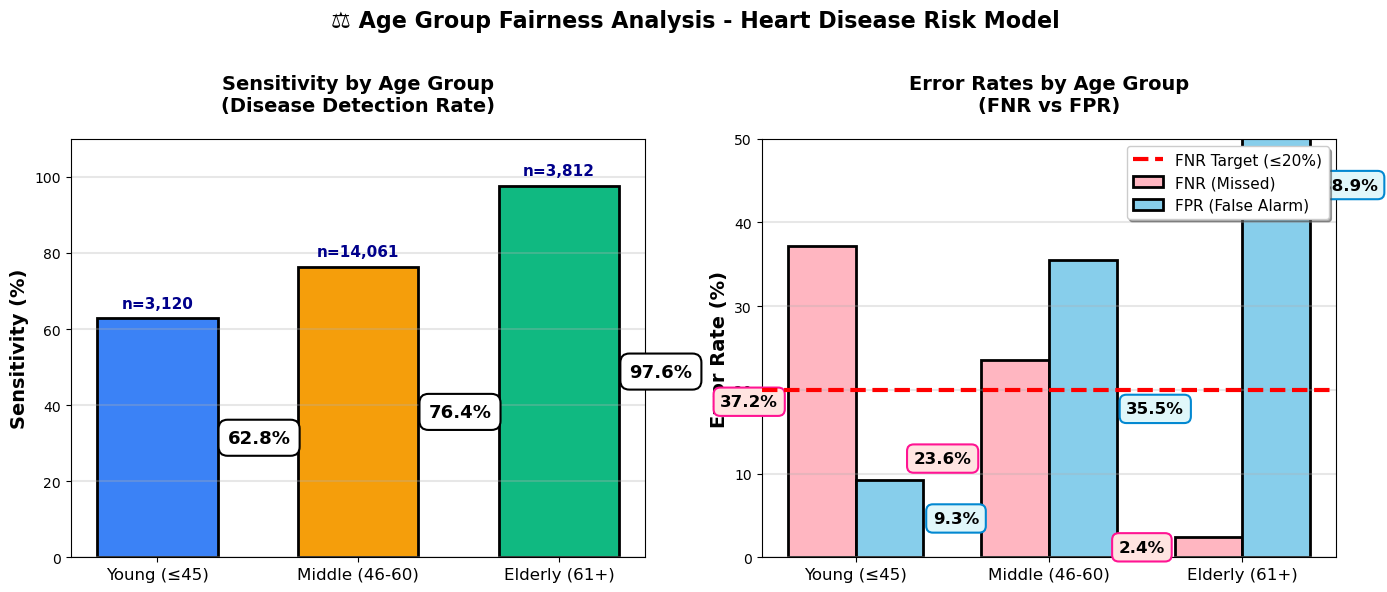


AGE GROUP FAIRNESS METRICS
     Age_Group  Sample  Disease_Rate  Sensitivity       FNR       FPR
   Young (≤45)    3120     31.217949    62.833676 37.166324  9.273066
Middle (46-60)   14061     49.455942    76.416451 23.583549 35.457999
 Elderly (61+)    3812     67.261280    97.620905  2.379095 88.942308

📊 Fairness Assessment:
   FNR Range: 2.4% - 37.2% (gap: 34.8%)
   Sensitivity Range: 62.8% - 97.6% (gap: 34.8%)
   Status: ⚠️ NEEDS REVIEW (FNR gap ≥ 5%)



In [4]:
"""
RAI ANALYSIS #2: AGE GROUP FAIRNESS
Analyzes model fairness across age groups (Young/Middle/Elderly)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import confusion_matrix

# ============================================================================
# SETUP
# ============================================================================
PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts'
DATA_DIR = ARTIFACTS_DIR / 'split data sets'
REPORTS_DIR = PROJECT_ROOT / 'reports' / 'modeling'
METRICS_DIR = REPORTS_DIR / 'metrics'
FIGURES_DIR = REPORTS_DIR / 'rai reports'
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

RANDOM_STATE = 42

print("\n" + "="*80)
print("⚖️ AGE GROUP FAIRNESS ANALYSIS")
print("="*80)

# ============================================================================
# LOAD DATA
# ============================================================================
print("\n[1/3] Loading data...")

# Load risk profiles
df_risk_profiles = pd.read_parquet(METRICS_DIR / 'df_risk_profiles.parquet')

# Load test data to get Age_Years
X_test_full = pd.read_parquet(DATA_DIR / 'X_test.parquet')

# Merge age data
X_test_indexed = X_test_full.reset_index(drop=True)
X_test_indexed['Patient_Index'] = X_test_indexed.index
df_demographics = X_test_indexed[['Patient_Index', 'Age_Years']].copy()

df_test = df_risk_profiles.merge(df_demographics, on='Patient_Index', how='left')

print(f"✓ Loaded: {len(df_test):,} patients")
print(f"✓ Age range: {df_test['Age_Years'].min():.1f} - {df_test['Age_Years'].max():.1f} years")

# ============================================================================
# CREATE AGE GROUPS
# ============================================================================
print("\n[2/3] Creating age groups...")

# Define age bins (adjusted for your dataset)
age_bins = [0, 45, 60, 100]
age_labels = ['Young (≤45)', 'Middle (46-60)', 'Elderly (61+)']

df_test['Age_Group'] = pd.cut(df_test['Age_Years'], bins=age_bins, labels=age_labels)

print(f"✓ Age group distribution:")
for label in age_labels:
    count = (df_test['Age_Group'] == label).sum()
    pct = count / len(df_test) * 100
    print(f"  {label:20s}: {count:5,} ({pct:5.1f}%)")

# ============================================================================
# CALCULATE METRICS
# ============================================================================
print("\n[3/3] Calculating fairness metrics...")

metrics = []
for age_group in age_labels:
    mask = df_test['Age_Group'] == age_group
    
    if mask.sum() == 0:
        print(f"⚠️  No patients in {age_group}")
        continue
    
    y_true = df_test[mask]['Actual_Disease'].values
    y_pred = df_test[mask]['Predicted_Disease'].values
    
    # Handle edge cases
    if len(np.unique(y_true)) < 2 or len(np.unique(y_pred)) < 2:
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        if cm.size == 4:
            tn, fp, fn, tp = cm.ravel()
        else:
            tn, fp, fn, tp = 0, 0, 0, 0
    else:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    sensitivity = (tp / (tp + fn) * 100) if (tp + fn) > 0 else 0
    fnr = (fn / (tp + fn) * 100) if (tp + fn) > 0 else 0
    fpr = (fp / (fp + tn) * 100) if (fp + tn) > 0 else 0
    
    metrics.append({
        'Age_Group': age_group,
        'Sensitivity': sensitivity,
        'FNR': fnr,
        'FPR': fpr,
        'Sample': int(mask.sum()),
        'Disease_Count': int(y_true.sum()),
        'Disease_Rate': float(y_true.mean() * 100),
        'TP': int(tp),
        'FP': int(fp),
        'TN': int(tn),
        'FN': int(fn)
    })
    
    print(f"  {age_group:20s}: n={mask.sum():5,} | Sens={sensitivity:5.1f}% | FNR={fnr:5.1f}% | FPR={fpr:5.1f}%")

df_metrics = pd.DataFrame(metrics)

# ============================================================================
# CREATE VISUALIZATION
# ============================================================================
print("\nCreating visualization...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('⚖️ Age Group Fairness Analysis - Heart Disease Risk Model', 
             fontsize=16, fontweight='bold', y=0.98)

# Color palette
colors = ['#3B82F6', '#F59E0B', '#10B981']

# ============================================
# LEFT: Sensitivity Comparison
# ============================================
x = np.arange(len(df_metrics))
width = 0.6

sensitivity_vals = df_metrics['Sensitivity'].values

bars = ax1.bar(x, sensitivity_vals, width, 
               color=colors, 
               edgecolor='black', linewidth=2)

ax1.set_ylabel('Sensitivity (%)', fontsize=14, fontweight='bold')
ax1.set_title('Sensitivity by Age Group\n(Disease Detection Rate)', 
              fontsize=14, fontweight='bold', pad=20)
ax1.set_xticks(x)
ax1.set_xticklabels(df_metrics['Age_Group'].values, fontsize=12)
ax1.set_ylim([0, 110])
ax1.grid(alpha=0.3, axis='y', linewidth=1.5)

# Add labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    # Value label to the right
    ax1.text(bar.get_x() + bar.get_width() + 0.05, height/2,
            f'{height:.1f}%',
            ha='left', va='center', fontweight='bold', fontsize=13,
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                     edgecolor='black', linewidth=1.5))
    
    # Sample size above
    ax1.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'n={df_metrics.iloc[i]["Sample"]:,}',
            ha='center', va='bottom', fontweight='bold', fontsize=11,
            color='darkblue')

# ============================================
# RIGHT: Error Rates Comparison
# ============================================
x = np.arange(len(df_metrics))
width = 0.35

fnr_vals = df_metrics['FNR'].values
fpr_vals = df_metrics['FPR'].values

bars1 = ax2.bar(x - width/2, fnr_vals, width, label='FNR (Missed)', 
                color='#FFB6C1', edgecolor='black', linewidth=2)
bars2 = ax2.bar(x + width/2, fpr_vals, width, label='FPR (False Alarm)', 
                color='#87CEEB', edgecolor='black', linewidth=2)

ax2.axhline(y=20, color='red', linestyle='--', linewidth=3, 
            label='FNR Target (≤20%)', zorder=5)

ax2.set_ylabel('Error Rate (%)', fontsize=14, fontweight='bold')
ax2.set_title('Error Rates by Age Group\n(FNR vs FPR)', 
              fontsize=14, fontweight='bold', pad=20)
ax2.set_xticks(x)
ax2.set_xticklabels(df_metrics['Age_Group'].values, fontsize=12)
ax2.set_ylim([0, 50])
ax2.legend(fontsize=11, frameon=True, shadow=True, loc='upper right')
ax2.grid(alpha=0.3, axis='y', linewidth=1.5)

# Add labels
for i, bar in enumerate(bars1):
    height = bar.get_height()
    if height > 0:
        ax2.text(bar.get_x() - 0.05, height/2,
                f'{height:.1f}%',
                ha='right', va='center', fontweight='bold', fontsize=12,
                bbox=dict(boxstyle='round,pad=0.4', facecolor='#FFE4E1', 
                         edgecolor='#FF1493', linewidth=1.5))

for i, bar in enumerate(bars2):
    height = bar.get_height()
    if height > 0:
        ax2.text(bar.get_x() + bar.get_width() + 0.05, height/2,
                f'{height:.1f}%',
                ha='left', va='center', fontweight='bold', fontsize=12,
                bbox=dict(boxstyle='round,pad=0.4', facecolor='#E0F7FA', 
                         edgecolor='#0288D1', linewidth=1.5))

plt.tight_layout(rect=[0, 0, 1, 0.96])

# ============================================================================
# SAVE
# ============================================================================
output_path = FIGURES_DIR / '02_age_fairness.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\n✅ Saved: {output_path}")
plt.show()
plt.close()

# ============================================================================
# FAIRNESS ASSESSMENT
# ============================================================================
print("\n" + "="*80)
print("AGE GROUP FAIRNESS METRICS")
print("="*80)
print(df_metrics[['Age_Group', 'Sample', 'Disease_Rate', 'Sensitivity', 'FNR', 'FPR']].to_string(index=False))

if len(df_metrics) >= 2:
    fnr_values = df_metrics['FNR'].values
    sens_values = df_metrics['Sensitivity'].values
    
    fnr_max = fnr_values.max()
    fnr_min = fnr_values.min()
    fnr_gap = fnr_max - fnr_min
    
    sens_max = sens_values.max()
    sens_min = sens_values.min()
    sens_gap = sens_max - sens_min
    
    print(f"\n📊 Fairness Assessment:")
    print(f"   FNR Range: {fnr_min:.1f}% - {fnr_max:.1f}% (gap: {fnr_gap:.1f}%)")
    print(f"   Sensitivity Range: {sens_min:.1f}% - {sens_max:.1f}% (gap: {sens_gap:.1f}%)")
    
    if fnr_gap < 5:
        print(f"   Status: ✅ PASS (FNR gap < 5%)")
    else:
        print(f"   Status: ⚠️ NEEDS REVIEW (FNR gap ≥ 5%)")

print("="*80 + "\n")



🔍 ERROR ANALYSIS: FALSE POSITIVES vs FALSE NEGATIVES

[1/3] Loading data...
✓ Loaded: 20,993 patients

[2/3] Classifying errors...

✓ Error distribution:
  Correct        : 15,101 ( 71.9%)
  False Positive : 3,829 ( 18.2%)
  False Negative : 2,063 (  9.8%)

[3/3] Analyzing errors by risk group...

✓ Error rates by risk group (%):
Error_Type  Correct  False Negative  False Positive
Risk_Level                                         
High           77.8             0.0            22.2
Low            80.6            19.4             0.0
Moderate       52.7            14.4            32.9

Creating visualization...


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16592\1505606670.py:230: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.97])
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16592\1505606670.py:236: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')



✅ Saved: p:\projects\heart_disease_prediction\reports\modeling\rai reports\03_error_analysis.png


p:\projects\heart_disease_prediction\env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


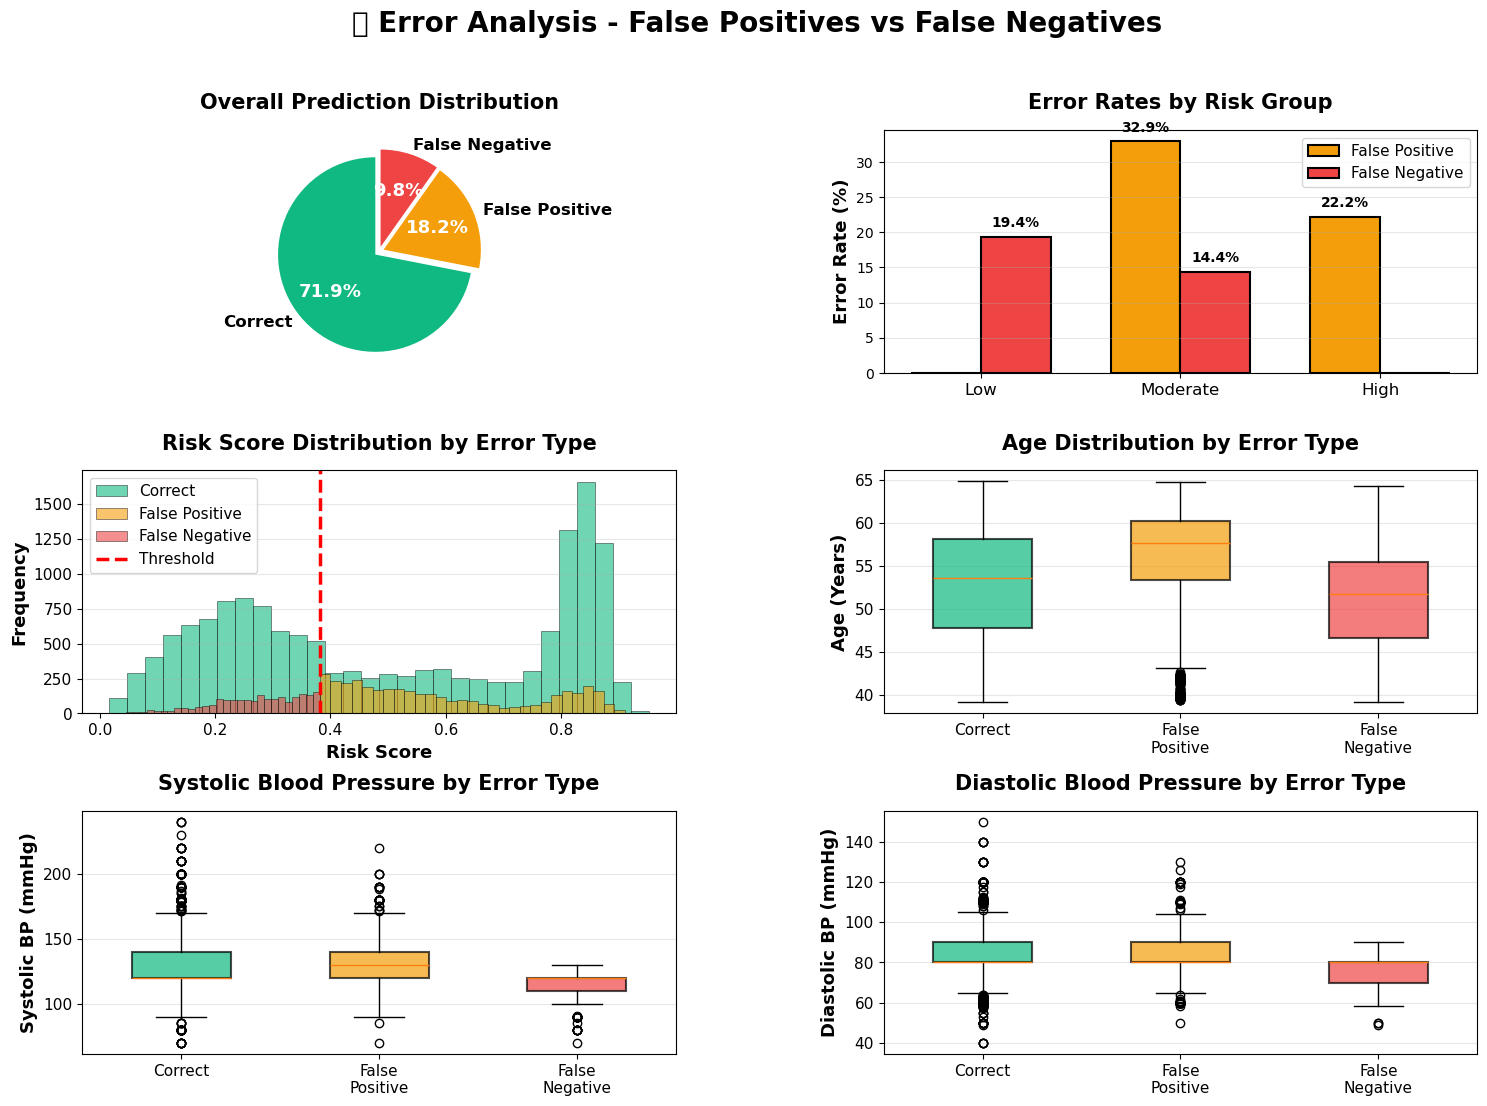


ERROR ANALYSIS SUMMARY

Total Patients: 20,993

Correct Predictions: 15,101 (71.9%)
False Positives:     3,829 (18.2%)
False Negatives:     2,063 (9.8%)

📊 Key Findings:
   Average risk score for FP: 0.598
   Average risk score for FN: 0.270
   Threshold: 0.382



In [6]:
"""
RAI ANALYSIS #3: ERROR ANALYSIS (IMPROVED SPACING)
Deep dive into False Positives and False Negatives
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ============================================================================
# SETUP
# ============================================================================
PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts'
DATA_DIR = ARTIFACTS_DIR / 'split data sets'
REPORTS_DIR = PROJECT_ROOT / 'reports' / 'modeling'
METRICS_DIR = REPORTS_DIR / 'metrics'
FIGURES_DIR = REPORTS_DIR / 'rai reports'
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print("\n" + "="*80)
print("🔍 ERROR ANALYSIS: FALSE POSITIVES vs FALSE NEGATIVES")
print("="*80)

# ============================================================================
# LOAD DATA
# ============================================================================
print("\n[1/3] Loading data...")

# Load risk profiles
df_risk_profiles = pd.read_parquet(METRICS_DIR / 'df_risk_profiles.parquet')

# Load test features
X_test_full = pd.read_parquet(DATA_DIR / 'X_test.parquet')
X_test_indexed = X_test_full.reset_index(drop=True)
X_test_indexed['Patient_Index'] = X_test_indexed.index

# Merge
df_test = df_risk_profiles.merge(X_test_indexed, on='Patient_Index', how='left')

print(f"✓ Loaded: {len(df_test):,} patients")

# ============================================================================
# CLASSIFY ERRORS
# ============================================================================
print("\n[2/3] Classifying errors...")

# Create error categories
df_test['Error_Type'] = 'Correct'
df_test.loc[(df_test['Actual_Disease'] == 0) & (df_test['Predicted_Disease'] == 1), 'Error_Type'] = 'False Positive'
df_test.loc[(df_test['Actual_Disease'] == 1) & (df_test['Predicted_Disease'] == 0), 'Error_Type'] = 'False Negative'

error_counts = df_test['Error_Type'].value_counts()
print(f"\n✓ Error distribution:")
for error_type, count in error_counts.items():
    pct = count / len(df_test) * 100
    print(f"  {error_type:15s}: {count:5,} ({pct:5.1f}%)")

# ============================================================================
# ERROR ANALYSIS BY RISK GROUP
# ============================================================================
print("\n[3/3] Analyzing errors by risk group...")

error_by_risk = pd.crosstab(df_test['Risk_Level'], df_test['Error_Type'], normalize='index') * 100

print("\n✓ Error rates by risk group (%):")
print(error_by_risk.round(1))

# ============================================================================
# CREATE VISUALIZATION (LARGER, BETTER SPACING)
# ============================================================================
print("\nCreating visualization...")

# ✅ Increased figure size from (16,10) to (18,12)
fig = plt.figure(figsize=(18, 12))
# ✅ Increased spacing: hspace from 0.3 to 0.4, wspace from 0.3 to 0.35
gs = fig.add_gridspec(3, 2, hspace=0.4, wspace=0.35)

fig.suptitle('🔍 Error Analysis - False Positives vs False Negatives', 
             fontsize=20, fontweight='bold', y=0.98)

# ============================================
# TOP LEFT: Overall Error Distribution
# ============================================
ax1 = fig.add_subplot(gs[0, 0])

error_data = df_test['Error_Type'].value_counts()
colors_error = {'Correct': '#10B981', 'False Positive': '#F59E0B', 'False Negative': '#EF4444'}
colors = [colors_error.get(x, 'gray') for x in error_data.index]

wedges, texts, autotexts = ax1.pie(error_data.values, labels=error_data.index, 
                                     autopct='%1.1f%%', colors=colors,
                                     explode=[0.05, 0.05, 0.05], startangle=90,
                                     textprops={'fontsize': 12, 'fontweight': 'bold'})

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(13)

ax1.set_title('Overall Prediction Distribution', fontsize=15, fontweight='bold', pad=15)

# ============================================
# TOP RIGHT: Errors by Risk Group
# ============================================
ax2 = fig.add_subplot(gs[0, 1])

risk_groups = ['Low', 'Moderate', 'High']
fp_rates = [error_by_risk.loc[risk, 'False Positive'] if risk in error_by_risk.index and 'False Positive' in error_by_risk.columns else 0 
            for risk in risk_groups]
fn_rates = [error_by_risk.loc[risk, 'False Negative'] if risk in error_by_risk.index and 'False Negative' in error_by_risk.columns else 0 
            for risk in risk_groups]

x = np.arange(len(risk_groups))
width = 0.35

bars1 = ax2.bar(x - width/2, fp_rates, width, label='False Positive', 
                color='#F59E0B', edgecolor='black', linewidth=1.5)
bars2 = ax2.bar(x + width/2, fn_rates, width, label='False Negative', 
                color='#EF4444', edgecolor='black', linewidth=1.5)

ax2.set_ylabel('Error Rate (%)', fontsize=13, fontweight='bold')
ax2.set_title('Error Rates by Risk Group', fontsize=15, fontweight='bold', pad=15)
ax2.set_xticks(x)
ax2.set_xticklabels(risk_groups, fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# ============================================
# MIDDLE LEFT: Risk Score Distribution by Error Type
# ============================================
ax3 = fig.add_subplot(gs[1, 0])

for error_type, color in [('Correct', '#10B981'), ('False Positive', '#F59E0B'), ('False Negative', '#EF4444')]:
    data = df_test[df_test['Error_Type'] == error_type]['Risk_Score']
    if len(data) > 0:
        ax3.hist(data, bins=30, alpha=0.6, label=error_type, color=color, edgecolor='black', linewidth=0.5)

ax3.axvline(df_test['Threshold'].iloc[0], color='red', linestyle='--', linewidth=2.5, label='Threshold')
ax3.set_xlabel('Risk Score', fontsize=13, fontweight='bold')
ax3.set_ylabel('Frequency', fontsize=13, fontweight='bold')
ax3.set_title('Risk Score Distribution by Error Type', fontsize=15, fontweight='bold', pad=15)
ax3.legend(fontsize=11)
ax3.grid(alpha=0.3, axis='y')
ax3.tick_params(labelsize=11)

# ============================================
# MIDDLE RIGHT: Age Distribution by Error Type
# ============================================
ax4 = fig.add_subplot(gs[1, 1])

fp_ages = df_test[df_test['Error_Type'] == 'False Positive']['Age_Years']
fn_ages = df_test[df_test['Error_Type'] == 'False Negative']['Age_Years']
correct_ages = df_test[df_test['Error_Type'] == 'Correct']['Age_Years']

bp = ax4.boxplot([correct_ages, fp_ages, fn_ages], 
                  labels=['Correct', 'False\nPositive', 'False\nNegative'],
                  patch_artist=True, widths=0.5)

colors_box = ['#10B981', '#F59E0B', '#EF4444']
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
    patch.set_linewidth(1.5)

ax4.set_ylabel('Age (Years)', fontsize=13, fontweight='bold')
ax4.set_title('Age Distribution by Error Type', fontsize=15, fontweight='bold', pad=15)
ax4.grid(alpha=0.3, axis='y')
ax4.tick_params(labelsize=11)

# ============================================
# BOTTOM LEFT: Systolic BP Distribution
# ============================================
ax5 = fig.add_subplot(gs[2, 0])

fp_sbp = df_test[df_test['Error_Type'] == 'False Positive']['Systolic_BP']
fn_sbp = df_test[df_test['Error_Type'] == 'False Negative']['Systolic_BP']
correct_sbp = df_test[df_test['Error_Type'] == 'Correct']['Systolic_BP']

bp_sbp = ax5.boxplot([correct_sbp, fp_sbp, fn_sbp], 
                      labels=['Correct', 'False\nPositive', 'False\nNegative'],
                      patch_artist=True, widths=0.5)

colors_box = ['#10B981', '#F59E0B', '#EF4444']
for patch, color in zip(bp_sbp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
    patch.set_linewidth(1.5)

ax5.set_ylabel('Systolic BP (mmHg)', fontsize=13, fontweight='bold')
ax5.set_title('Systolic Blood Pressure by Error Type', fontsize=15, fontweight='bold', pad=15)
ax5.grid(alpha=0.3, axis='y')
ax5.tick_params(labelsize=11)

# ============================================
# BOTTOM RIGHT: Diastolic BP Distribution
# ============================================
ax6 = fig.add_subplot(gs[2, 1])

fp_dbp = df_test[df_test['Error_Type'] == 'False Positive']['Diastolic_BP']
fn_dbp = df_test[df_test['Error_Type'] == 'False Negative']['Diastolic_BP']
correct_dbp = df_test[df_test['Error_Type'] == 'Correct']['Diastolic_BP']

bp_dbp = ax6.boxplot([correct_dbp, fp_dbp, fn_dbp], 
                      labels=['Correct', 'False\nPositive', 'False\nNegative'],
                      patch_artist=True, widths=0.5)

colors_box = ['#10B981', '#F59E0B', '#EF4444']
for patch, color in zip(bp_dbp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
    patch.set_linewidth(1.5)

ax6.set_ylabel('Diastolic BP (mmHg)', fontsize=13, fontweight='bold')
ax6.set_title('Diastolic Blood Pressure by Error Type', fontsize=15, fontweight='bold', pad=15)
ax6.grid(alpha=0.3, axis='y')
ax6.tick_params(labelsize=11)

plt.tight_layout(rect=[0, 0, 1, 0.97])

# ============================================================================
# SAVE
# ============================================================================
output_path = FIGURES_DIR / '03_error_analysis.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\n✅ Saved: {output_path}")
plt.show()
plt.close()

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================
print("\n" + "="*80)
print("ERROR ANALYSIS SUMMARY")
print("="*80)

print(f"\nTotal Patients: {len(df_test):,}")
print(f"\nCorrect Predictions: {error_counts.get('Correct', 0):,} ({error_counts.get('Correct', 0)/len(df_test)*100:.1f}%)")
print(f"False Positives:     {error_counts.get('False Positive', 0):,} ({error_counts.get('False Positive', 0)/len(df_test)*100:.1f}%)")
print(f"False Negatives:     {error_counts.get('False Negative', 0):,} ({error_counts.get('False Negative', 0)/len(df_test)*100:.1f}%)")

print("\n📊 Key Findings:")
fp_mean_risk = df_test[df_test['Error_Type'] == 'False Positive']['Risk_Score'].mean()
fn_mean_risk = df_test[df_test['Error_Type'] == 'False Negative']['Risk_Score'].mean()

print(f"   Average risk score for FP: {fp_mean_risk:.3f}")
print(f"   Average risk score for FN: {fn_mean_risk:.3f}")
print(f"   Threshold: {df_test['Threshold'].iloc[0]:.3f}")

print("="*80 + "\n")


📊 PERFORMANCE BY RISK GROUPS

[1/2] Loading data...
✓ Loaded: 20,993 patients

[2/2] Calculating metrics...
  Low     : n=6,469 | Disease= 19.4%
  Moderate: n=5,616 | Disease= 41.2%
  High    : n=8,908 | Disease= 77.8%

Creating visualization...


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16592\3131235099.py:219: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.97])
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16592\3131235099.py:225: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')



✅ Saved: p:\projects\heart_disease_prediction\reports\modeling\rai reports\04_performance_by_risk_group.png


p:\projects\heart_disease_prediction\env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


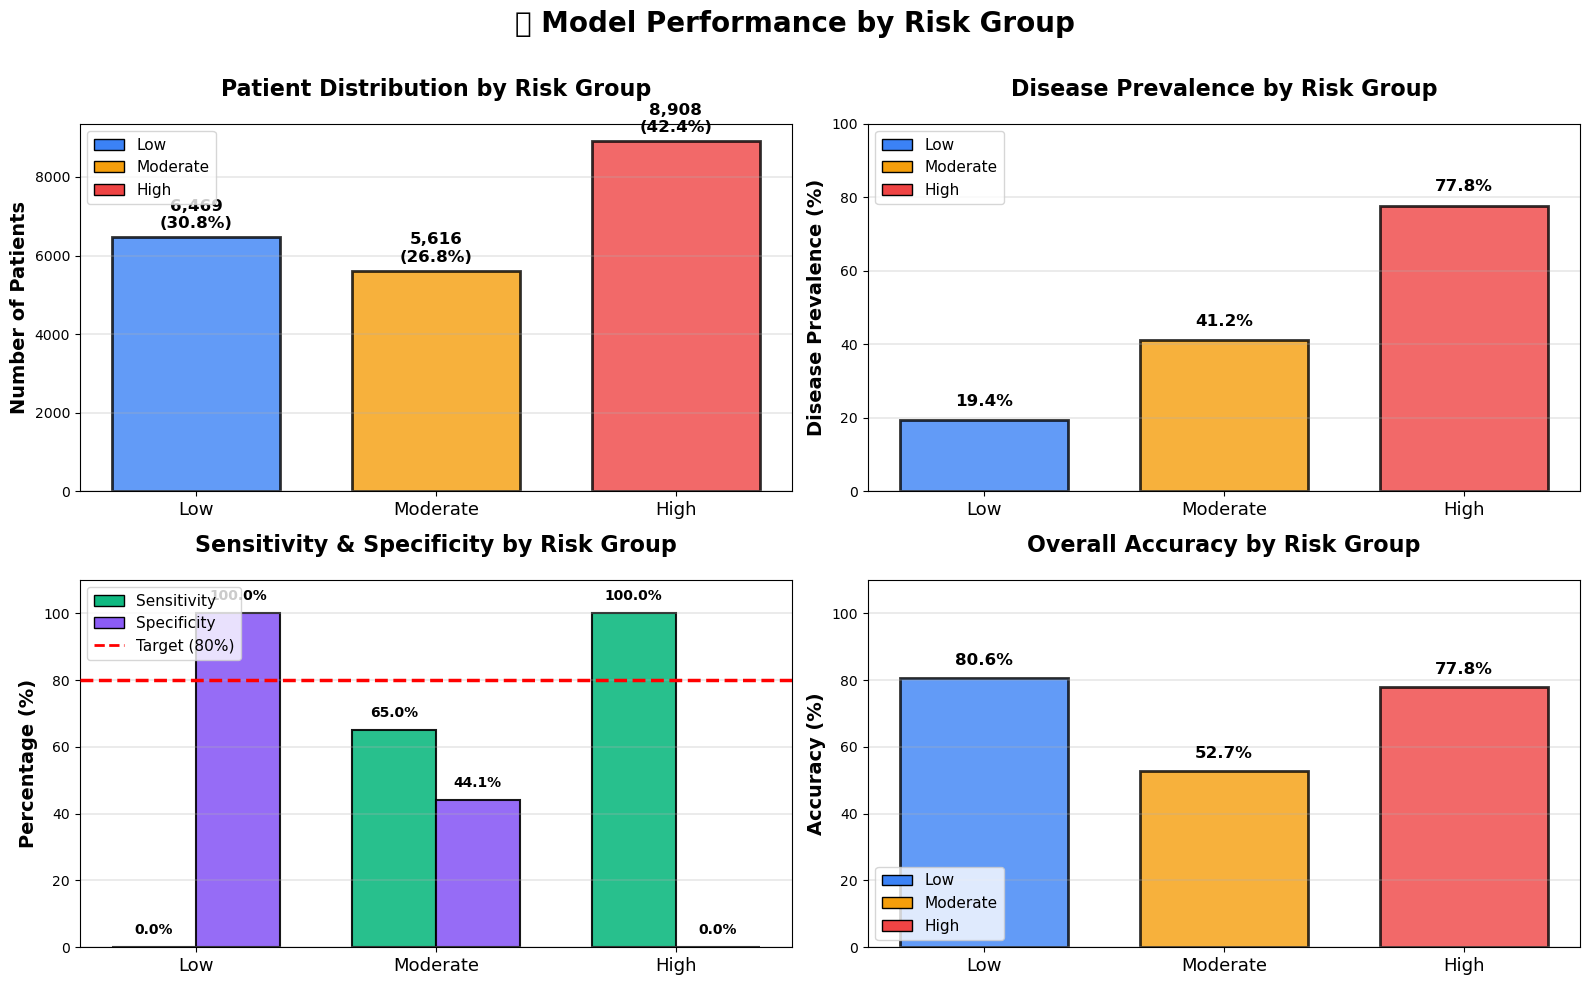


COMPLETE!



In [12]:
"""
RAI ANALYSIS #4: PERFORMANCE BY RISK GROUPS (FINAL FIX)
Graph 3: Colors by metric (Sensitivity/Specificity)
Graphs 1,2,4: Colors by risk group (Low/Moderate/High)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from pathlib import Path
from sklearn.metrics import confusion_matrix

# ============================================================================
# SETUP
# ============================================================================
PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts'
DATA_DIR = ARTIFACTS_DIR / 'split data sets'
REPORTS_DIR = PROJECT_ROOT / 'reports' / 'modeling'
METRICS_DIR = REPORTS_DIR / 'metrics'
FIGURES_DIR = REPORTS_DIR / 'rai reports'
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print("\n" + "="*80)
print("📊 PERFORMANCE BY RISK GROUPS")
print("="*80)

# ============================================================================
# LOAD DATA
# ============================================================================
print("\n[1/2] Loading data...")

df_risk_profiles = pd.read_parquet(METRICS_DIR / 'df_risk_profiles.parquet')
print(f"✓ Loaded: {len(df_risk_profiles):,} patients")

# ============================================================================
# CALCULATE METRICS
# ============================================================================
print("\n[2/2] Calculating metrics...")

metrics = []
risk_groups = ['Low', 'Moderate', 'High']

for risk_level in risk_groups:
    mask = df_risk_profiles['Risk_Level'] == risk_level
    
    if mask.sum() == 0:
        continue
    
    y_true = df_risk_profiles[mask]['Actual_Disease'].values
    y_pred = df_risk_profiles[mask]['Predicted_Disease'].values
    
    n_total = len(y_true)
    disease_rate = y_true.mean() * 100
    
    if len(np.unique(y_true)) < 2 or len(np.unique(y_pred)) < 2:
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        if cm.size == 4:
            tn, fp, fn, tp = cm.ravel()
        else:
            tn, fp, fn, tp = 0, 0, 0, 0
    else:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    sensitivity = (tp / (tp + fn) * 100) if (tp + fn) > 0 else 0
    specificity = (tn / (tn + fp) * 100) if (tn + fp) > 0 else 0
    accuracy = ((tp + tn) / n_total * 100) if n_total > 0 else 0
    
    metrics.append({
        'Risk_Level': risk_level,
        'N': n_total,
        'Disease_Rate': disease_rate,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Accuracy': accuracy
    })
    
    print(f"  {risk_level:8s}: n={n_total:5,} | Disease={disease_rate:5.1f}%")

df_metrics = pd.DataFrame(metrics)

# ============================================================================
# CREATE VISUALIZATION
# ============================================================================
print("\nCreating visualization...")

# Risk group colors (for graphs 1, 2, 4)
COLORS_RISK = ['#3B82F6', '#F59E0B', '#EF4444']  # Blue, Orange, Red

# Metric colors (for graph 3)
COLOR_SENSITIVITY = '#10B981'  # Green
COLOR_SPECIFICITY = '#8B5CF6'  # Purple

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('📊 Model Performance by Risk Group', 
             fontsize=20, fontweight='bold', y=0.98)

plt.subplots_adjust(hspace=0.3, wspace=0.3)

x = np.arange(len(df_metrics))
width = 0.7
width_sub = 0.35

# Legend for risk groups (graphs 1, 2, 4)
legend_risk_groups = [
    Patch(facecolor=COLORS_RISK[0], edgecolor='black', label='Low'),
    Patch(facecolor=COLORS_RISK[1], edgecolor='black', label='Moderate'),
    Patch(facecolor=COLORS_RISK[2], edgecolor='black', label='High')
]

# ============================================
# TOP LEFT: Patient Distribution (✅ RISK COLORS)
# ============================================
ax = axes[0, 0]
bars = ax.bar(x, df_metrics['N'], width, color=COLORS_RISK, 
              edgecolor='black', linewidth=2, alpha=0.8)

ax.set_ylabel('Number of Patients', fontsize=14, fontweight='bold')
ax.set_title('Patient Distribution by Risk Group', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(df_metrics['Risk_Level'], fontsize=13)
ax.grid(alpha=0.3, axis='y', linewidth=1.2)

for i, bar in enumerate(bars):
    height = bar.get_height()
    pct = df_metrics.iloc[i]['N'] / df_metrics['N'].sum() * 100
    ax.text(bar.get_x() + bar.get_width()/2., height + 150,
            f'{int(height):,}\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.legend(handles=legend_risk_groups, fontsize=11, loc='upper left')

# ============================================
# TOP RIGHT: Disease Prevalence (✅ RISK COLORS)
# ============================================
ax = axes[0, 1]
bars = ax.bar(x, df_metrics['Disease_Rate'], width, color=COLORS_RISK,
              edgecolor='black', linewidth=2, alpha=0.8)

ax.set_ylabel('Disease Prevalence (%)', fontsize=14, fontweight='bold')
ax.set_title('Disease Prevalence by Risk Group', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(df_metrics['Risk_Level'], fontsize=13)
ax.set_ylim([0, 100])
ax.grid(alpha=0.3, axis='y', linewidth=1.2)

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 3,
            f'{height:.1f}%',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.legend(handles=legend_risk_groups, fontsize=11, loc='upper left')

# ============================================
# BOTTOM LEFT: Sensitivity & Specificity (✅ METRIC COLORS)
# ============================================
ax = axes[1, 0]

# ✅ Use METRIC colors (all Sensitivity bars same color, all Specificity bars same color)
for i in range(3):
    sens = df_metrics.iloc[i]['Sensitivity']
    spec = df_metrics.iloc[i]['Specificity']
    
    # Sensitivity = Green, Specificity = Purple (consistent across all risk groups)
    ax.bar(i - width_sub/2, sens, width_sub, color=COLOR_SENSITIVITY, 
           edgecolor='black', linewidth=1.5, alpha=0.9)
    ax.bar(i + width_sub/2, spec, width_sub, color=COLOR_SPECIFICITY, 
           edgecolor='black', linewidth=1.5, alpha=0.9)
    
    ax.text(i - width_sub/2, sens + 3, f'{sens:.1f}%', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')
    ax.text(i + width_sub/2, spec + 3, f'{spec:.1f}%', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.axhline(y=80, color='red', linestyle='--', linewidth=2.5, zorder=5)

ax.set_ylabel('Percentage (%)', fontsize=14, fontweight='bold')
ax.set_title('Sensitivity & Specificity by Risk Group', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(df_metrics['Risk_Level'], fontsize=13)
ax.set_ylim([0, 110])
ax.grid(alpha=0.3, axis='y', linewidth=1.2)

# ✅ Legend shows METRIC colors (not risk colors)
legend_sens_spec = [
    Patch(facecolor=COLOR_SENSITIVITY, edgecolor='black', label='Sensitivity'),
    Patch(facecolor=COLOR_SPECIFICITY, edgecolor='black', label='Specificity'),
    plt.Line2D([0], [0], color='red', linestyle='--', linewidth=2, label='Target (80%)')
]
ax.legend(handles=legend_sens_spec, fontsize=11, loc='upper left')

# ============================================
# BOTTOM RIGHT: Accuracy (✅ RISK COLORS)
# ============================================
ax = axes[1, 1]
bars = ax.bar(x, df_metrics['Accuracy'], width, color=COLORS_RISK,
              edgecolor='black', linewidth=2, alpha=0.8)

ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
ax.set_title('Overall Accuracy by Risk Group', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(df_metrics['Risk_Level'], fontsize=13)
ax.set_ylim([0, 110])
ax.grid(alpha=0.3, axis='y', linewidth=1.2)

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 3,
            f'{height:.1f}%',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.legend(handles=legend_risk_groups, fontsize=11, loc='lower left')

plt.tight_layout(rect=[0, 0, 1, 0.97])

# ============================================================================
# SAVE
# ============================================================================
output_path = FIGURES_DIR / '04_performance_by_risk_group.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\n✅ Saved: {output_path}")
plt.show()
plt.close()

print("\n" + "="*80)
print("COMPLETE!")
print("="*80 + "\n")


📈 RISK SCORE DISTRIBUTION ANALYSIS

[1/3] Loading data...
✓ Loaded: 20,993 patients

[2/3] Creating visualization...


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16592\657616835.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.97])
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16592\657616835.py:158: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')



✅ Saved: p:\projects\heart_disease_prediction\reports\modeling\rai reports\05_risk_score_distribution.png


p:\projects\heart_disease_prediction\env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


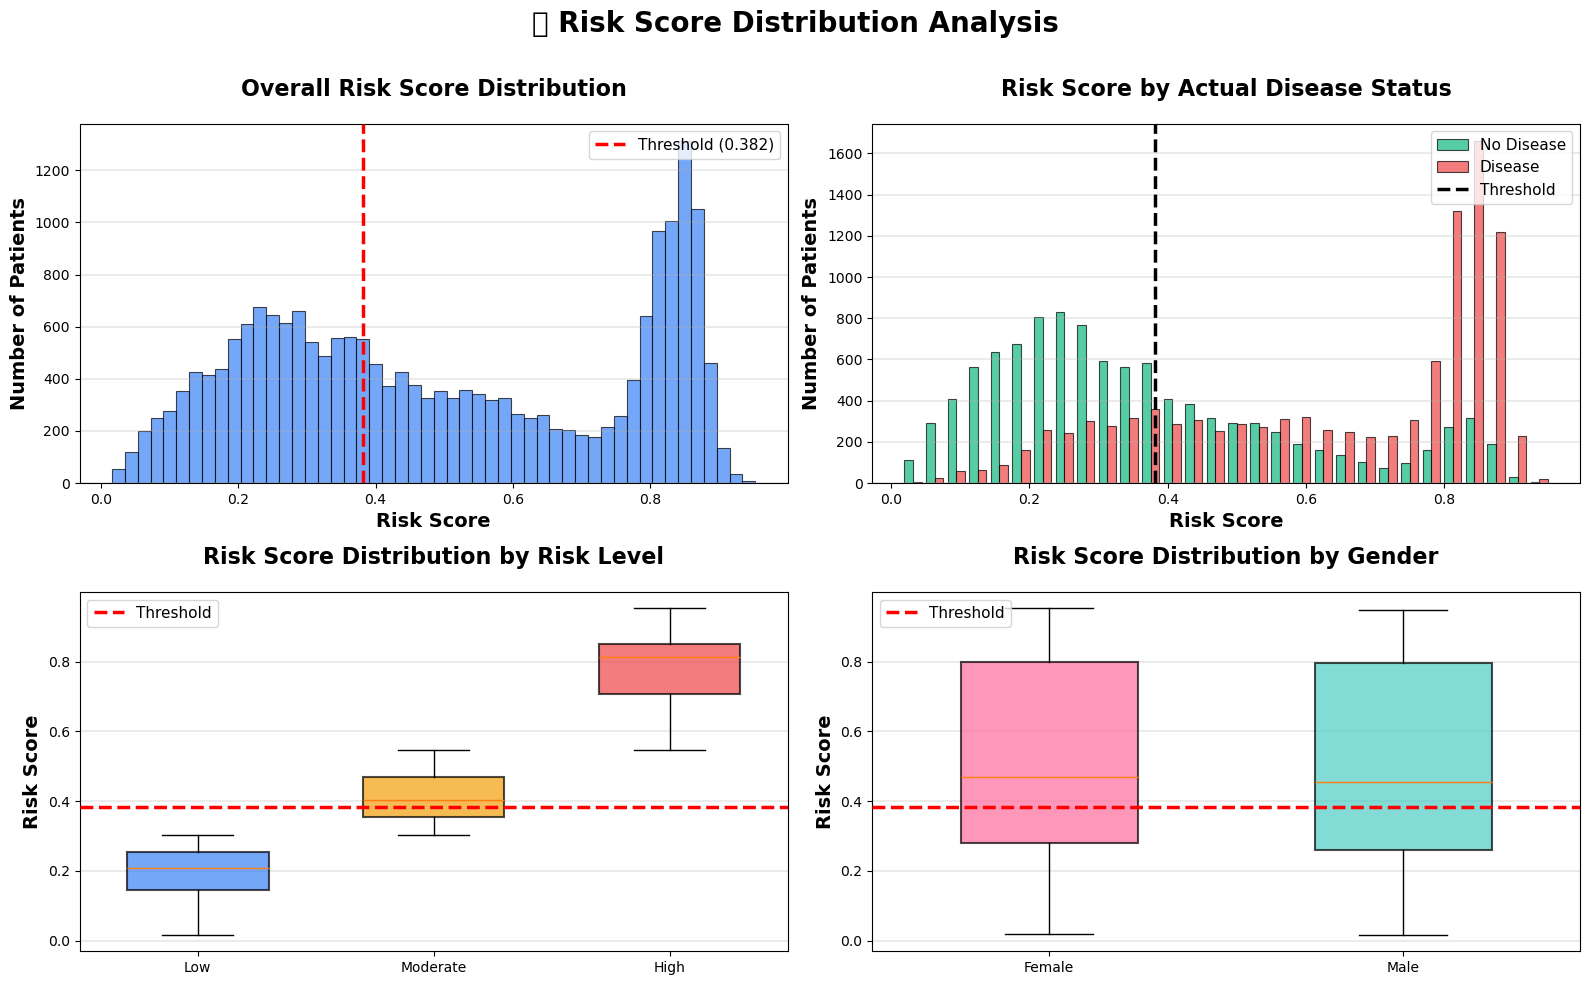


[3/3] Summary statistics...

RISK SCORE DISTRIBUTION SUMMARY

Overall Statistics:
  Mean Risk Score:   0.5000
  Median Risk Score: 0.4595
  Std Dev:           0.2637
  Min:               0.0161
  Max:               0.9526
  Threshold:         0.3818

By Actual Disease Status:
  No Disease:  Mean=0.3608, Median=0.3058
  Has Disease: Mean=0.6392, Median=0.7458

By Risk Level:
  Low:      Mean=0.1972, Median=0.2081
  Moderate: Mean=0.4124, Median=0.4037
  High:     Mean=0.7750, Median=0.8124

By Gender:
  Female: Mean=0.5069, Median=0.4682
  Male:   Mean=0.4962, Median=0.4543



In [14]:
"""
RAI ANALYSIS #5: RISK SCORE DISTRIBUTION ANALYSIS (FIXED)
Distribution of risk scores across different patient groups
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ============================================================================
# SETUP
# ============================================================================
PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts'
DATA_DIR = ARTIFACTS_DIR / 'split data sets'
REPORTS_DIR = PROJECT_ROOT / 'reports' / 'modeling'
METRICS_DIR = REPORTS_DIR / 'metrics'
FIGURES_DIR = REPORTS_DIR / 'rai reports'
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print("\n" + "="*80)
print("📈 RISK SCORE DISTRIBUTION ANALYSIS")
print("="*80)

# ============================================================================
# LOAD DATA
# ============================================================================
print("\n[1/3] Loading data...")

df_risk_profiles = pd.read_parquet(METRICS_DIR / 'df_risk_profiles.parquet')
X_test_full = pd.read_parquet(DATA_DIR / 'X_test.parquet')

# Merge demographics
X_test_indexed = X_test_full.reset_index(drop=True)
X_test_indexed['Patient_Index'] = X_test_indexed.index
df_test = df_risk_profiles.merge(X_test_indexed[['Patient_Index', 'Sex', 'Age_Years']], 
                                   on='Patient_Index', how='left')

df_test['Sex'] = df_test['Sex'].map({0: 'Female', 1: 'Male'})

print(f"✓ Loaded: {len(df_test):,} patients")

# ============================================================================
# CREATE VISUALIZATION (2×2 GRID)
# ============================================================================
print("\n[2/3] Creating visualization...")

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('📈 Risk Score Distribution Analysis', 
             fontsize=20, fontweight='bold', y=0.98)

plt.subplots_adjust(hspace=0.3, wspace=0.3)

threshold = df_test['Threshold'].iloc[0]

# ============================================
# TOP LEFT: Overall Risk Score Distribution
# ============================================
ax = axes[0, 0]

ax.hist(df_test['Risk_Score'], bins=50, color='#3B82F6', 
        edgecolor='black', linewidth=0.8, alpha=0.7)

ax.axvline(threshold, color='red', linestyle='--', linewidth=2.5, 
           label=f'Threshold ({threshold:.3f})', zorder=5)

ax.set_xlabel('Risk Score', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Patients', fontsize=14, fontweight='bold')
ax.set_title('Overall Risk Score Distribution', fontsize=16, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='upper right')
ax.grid(alpha=0.3, axis='y', linewidth=1.2)

# ============================================
# TOP RIGHT: Risk Score by Actual Disease Status
# ============================================
ax = axes[0, 1]

no_disease = df_test[df_test['Actual_Disease'] == 0]['Risk_Score']
has_disease = df_test[df_test['Actual_Disease'] == 1]['Risk_Score']

ax.hist([no_disease, has_disease], bins=30, 
        color=['#10B981', '#EF4444'], 
        label=['No Disease', 'Disease'], 
        edgecolor='black', linewidth=0.8, alpha=0.7)

ax.axvline(threshold, color='black', linestyle='--', linewidth=2.5, 
           label='Threshold', zorder=5)

ax.set_xlabel('Risk Score', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Patients', fontsize=14, fontweight='bold')
ax.set_title('Risk Score by Actual Disease Status', fontsize=16, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='upper right')
ax.grid(alpha=0.3, axis='y', linewidth=1.2)

# ============================================
# BOTTOM LEFT: Risk Score by Risk Level
# ============================================
ax = axes[1, 0]

low_risk = df_test[df_test['Risk_Level'] == 'Low']['Risk_Score']
mod_risk = df_test[df_test['Risk_Level'] == 'Moderate']['Risk_Score']
high_risk = df_test[df_test['Risk_Level'] == 'High']['Risk_Score']

bp = ax.boxplot([low_risk, mod_risk, high_risk], 
                 labels=['Low', 'Moderate', 'High'],
                 patch_artist=True, widths=0.6)

colors = ['#3B82F6', '#F59E0B', '#EF4444']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
    patch.set_linewidth(1.5)

ax.axhline(threshold, color='red', linestyle='--', linewidth=2.5, 
           label='Threshold', zorder=5)

ax.set_ylabel('Risk Score', fontsize=14, fontweight='bold')
ax.set_title('Risk Score Distribution by Risk Level', fontsize=16, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='upper left')
ax.grid(alpha=0.3, axis='y', linewidth=1.2)

# ============================================
# BOTTOM RIGHT: Risk Score by Gender
# ============================================
ax = axes[1, 1]

female_risk = df_test[df_test['Sex'] == 'Female']['Risk_Score']
male_risk = df_test[df_test['Sex'] == 'Male']['Risk_Score']

bp_gender = ax.boxplot([female_risk, male_risk], 
                        labels=['Female', 'Male'],
                        patch_artist=True, widths=0.5)

colors_gender = ['#FF6B9D', '#4ECDC4']
for patch, color in zip(bp_gender['boxes'], colors_gender):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
    patch.set_linewidth(1.5)

ax.axhline(threshold, color='red', linestyle='--', linewidth=2.5, 
           label='Threshold', zorder=5)

ax.set_ylabel('Risk Score', fontsize=14, fontweight='bold')
ax.set_title('Risk Score Distribution by Gender', fontsize=16, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='upper left')
ax.grid(alpha=0.3, axis='y', linewidth=1.2)

plt.tight_layout(rect=[0, 0, 1, 0.97])

# ============================================================================
# SAVE
# ============================================================================
output_path = FIGURES_DIR / '05_risk_score_distribution.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\n✅ Saved: {output_path}")
plt.show()
plt.close()

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================
print("\n[3/3] Summary statistics...")

print("\n" + "="*80)
print("RISK SCORE DISTRIBUTION SUMMARY")
print("="*80)

print(f"\nOverall Statistics:")
print(f"  Mean Risk Score:   {df_test['Risk_Score'].mean():.4f}")
print(f"  Median Risk Score: {df_test['Risk_Score'].median():.4f}")
print(f"  Std Dev:           {df_test['Risk_Score'].std():.4f}")
print(f"  Min:               {df_test['Risk_Score'].min():.4f}")
print(f"  Max:               {df_test['Risk_Score'].max():.4f}")
print(f"  Threshold:         {threshold:.4f}")

print(f"\nBy Actual Disease Status:")
print(f"  No Disease:  Mean={no_disease.mean():.4f}, Median={no_disease.median():.4f}")
print(f"  Has Disease: Mean={has_disease.mean():.4f}, Median={has_disease.median():.4f}")

print(f"\nBy Risk Level:")
print(f"  Low:      Mean={low_risk.mean():.4f}, Median={low_risk.median():.4f}")
print(f"  Moderate: Mean={mod_risk.mean():.4f}, Median={mod_risk.median():.4f}")
print(f"  High:     Mean={high_risk.mean():.4f}, Median={high_risk.median():.4f}")

print(f"\nBy Gender:")
print(f"  Female: Mean={female_risk.mean():.4f}, Median={female_risk.median():.4f}")
print(f"  Male:   Mean={male_risk.mean():.4f}, Median={male_risk.median():.4f}")

print("="*80 + "\n")


📐 CALIBRATION ANALYSIS

[1/3] Loading data...
✓ Loaded: 20,993 patients

[2/3] Creating calibration curves...


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16592\1337421028.py:196: UserWarning: Glyph 128208 (\N{TRIANGULAR RULER}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.97])
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16592\1337421028.py:202: UserWarning: Glyph 128208 (\N{TRIANGULAR RULER}) missing from current font.
  plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')



✅ Saved: p:\projects\heart_disease_prediction\reports\modeling\rai reports\06_calibration_analysis.png


p:\projects\heart_disease_prediction\env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128208 (\N{TRIANGULAR RULER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


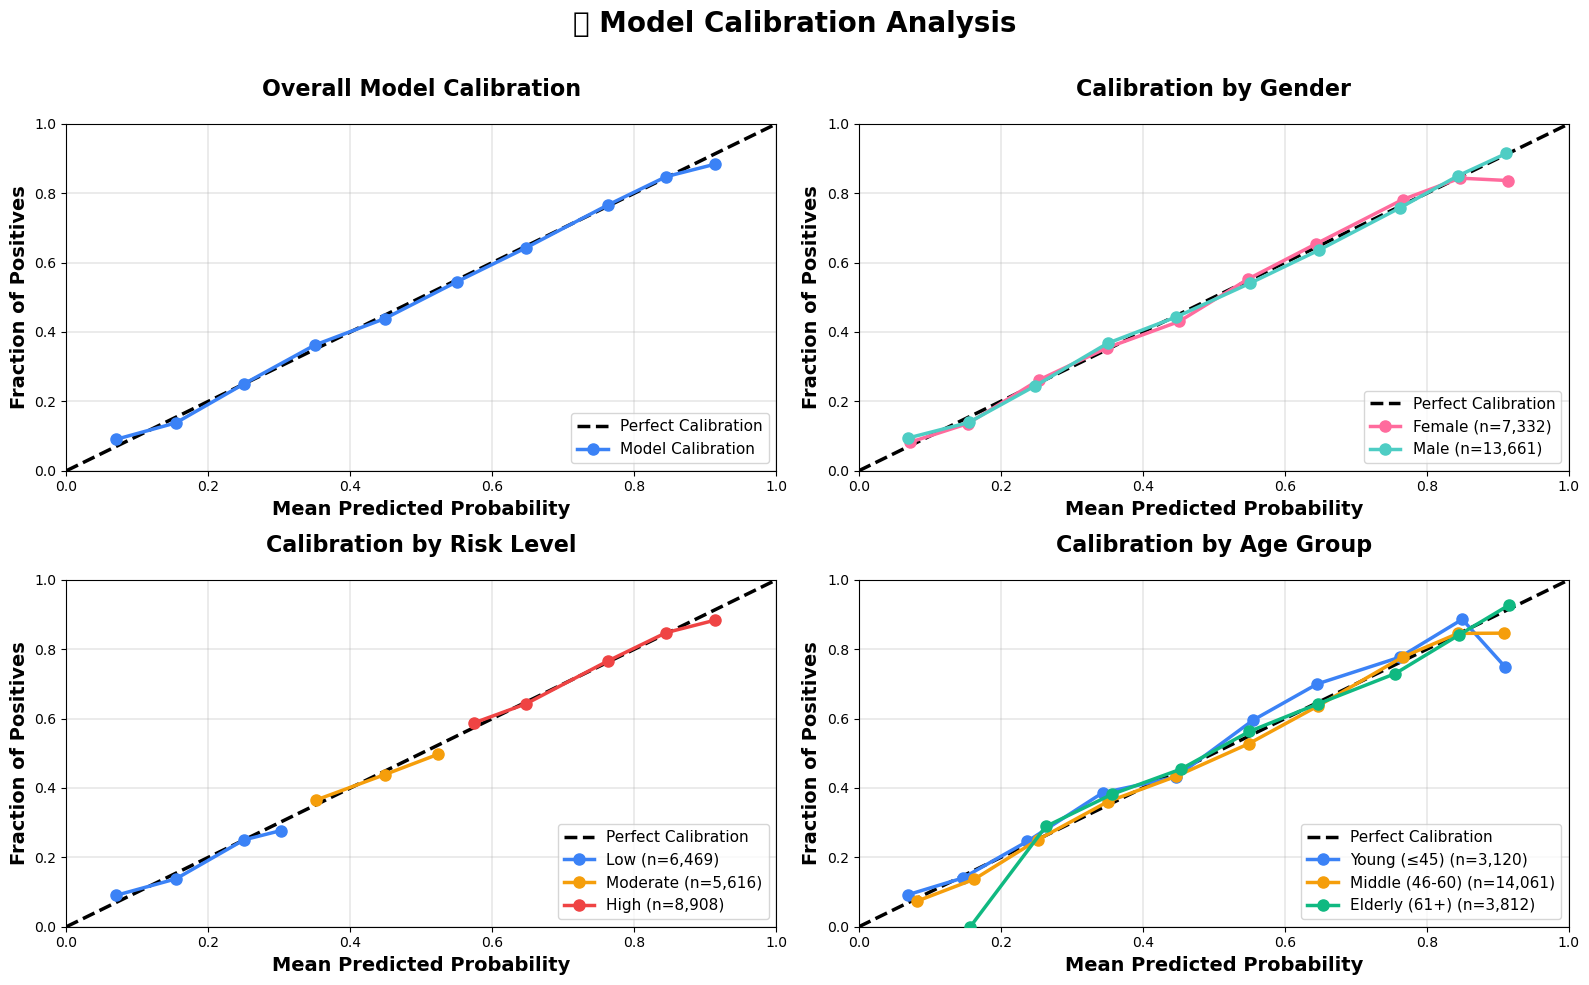


[3/3] Calculating calibration metrics...

CALIBRATION METRICS

Overall Calibration:
  Brier Score:  0.1803 (lower is better, range 0-1)
  Log Loss:     0.5409 (lower is better)

By Gender:
  Female: Brier=0.1813, LogLoss=0.5434
  Male  : Brier=0.1798, LogLoss=0.5395

By Risk Level:
  Low     : Brier=0.1521, LogLoss=0.4774
  Moderate: Brier=0.2395, LogLoss=0.6719
  High    : Brier=0.1635, LogLoss=0.5043

💡 Interpretation:
   - Points close to diagonal = well calibrated
   - Points above diagonal = underestimating risk
   - Points below diagonal = overestimating risk
   - Brier score: 0 = perfect, 1 = worst



In [ ]:
"""
RAI ANALYSIS #6: CALIBRATION ANALYSIS
Assessing reliability of predicted probabilities across subgroups
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.calibration import calibration_curve

# ============================================================================
# SETUP
# ============================================================================
PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts'
DATA_DIR = ARTIFACTS_DIR / 'split data sets'
REPORTS_DIR = PROJECT_ROOT / 'reports' / 'modeling'
METRICS_DIR = REPORTS_DIR / 'metrics'
FIGURES_DIR = REPORTS_DIR / 'rai reports'
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print("\n" + "="*80)
print("📐 CALIBRATION ANALYSIS")
print("="*80)

# ============================================================================
# LOAD DATA
# ============================================================================
print("\n[1/3] Loading data...")

df_risk_profiles = pd.read_parquet(METRICS_DIR / 'df_risk_profiles.parquet')
X_test_full = pd.read_parquet(DATA_DIR / 'X_test.parquet')

# Merge demographics
X_test_indexed = X_test_full.reset_index(drop=True)
X_test_indexed['Patient_Index'] = X_test_indexed.index
df_test = df_risk_profiles.merge(X_test_indexed[['Patient_Index', 'Sex', 'Age_Years']], 
                                   on='Patient_Index', how='left')

df_test['Sex'] = df_test['Sex'].map({0: 'Female', 1: 'Male'})

print(f"✓ Loaded: {len(df_test):,} patients")

# ============================================================================
# CREATE VISUALIZATION
# ============================================================================
print("\n[2/3] Creating calibration curves...")

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('📐 Model Calibration Analysis', 
             fontsize=20, fontweight='bold', y=0.98)

plt.subplots_adjust(hspace=0.3, wspace=0.3)

# ============================================
# TOP LEFT: Overall Calibration
# ============================================
ax = axes[0, 0]

try:
    fraction_of_positives, mean_predicted_value = calibration_curve(
        df_test['Actual_Disease'], 
        df_test['Risk_Score'], 
        n_bins=10, 
        strategy='uniform'
    )
    
    ax.plot([0, 1], [0, 1], 'k--', linewidth=2.5, label='Perfect Calibration', zorder=5)
    ax.plot(mean_predicted_value, fraction_of_positives, 'o-', 
            color='#3B82F6', linewidth=2.5, markersize=8, 
            label='Model Calibration', zorder=10)
    
    ax.set_xlabel('Mean Predicted Probability', fontsize=14, fontweight='bold')
    ax.set_ylabel('Fraction of Positives', fontsize=14, fontweight='bold')
    ax.set_title('Overall Model Calibration', fontsize=16, fontweight='bold', pad=20)
    ax.legend(fontsize=11, loc='lower right')
    ax.grid(alpha=0.3, linewidth=1.2)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    
except Exception as e:
    ax.text(0.5, 0.5, f'Calibration Error: {str(e)}', 
            ha='center', va='center', fontsize=12)

# ============================================
# TOP RIGHT: Calibration by Gender
# ============================================
ax = axes[0, 1]

ax.plot([0, 1], [0, 1], 'k--', linewidth=2.5, label='Perfect Calibration', zorder=5)

colors_gender = {'Female': '#FF6B9D', 'Male': '#4ECDC4'}

for sex in ['Female', 'Male']:
    mask = df_test['Sex'] == sex
    if mask.sum() > 0:
        try:
            y_true = df_test[mask]['Actual_Disease']
            y_prob = df_test[mask]['Risk_Score']
            
            fraction_of_positives, mean_predicted_value = calibration_curve(
                y_true, y_prob, n_bins=10, strategy='uniform'
            )
            
            ax.plot(mean_predicted_value, fraction_of_positives, 'o-', 
                    color=colors_gender[sex], linewidth=2.5, markersize=8,
                    label=f'{sex} (n={mask.sum():,})', zorder=10)
        except:
            pass

ax.set_xlabel('Mean Predicted Probability', fontsize=14, fontweight='bold')
ax.set_ylabel('Fraction of Positives', fontsize=14, fontweight='bold')
ax.set_title('Calibration by Gender', fontsize=16, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='lower right')
ax.grid(alpha=0.3, linewidth=1.2)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

# ============================================
# BOTTOM LEFT: Calibration by Risk Level
# ============================================
ax = axes[1, 0]

ax.plot([0, 1], [0, 1], 'k--', linewidth=2.5, label='Perfect Calibration', zorder=5)

colors_risk = {'Low': '#3B82F6', 'Moderate': '#F59E0B', 'High': '#EF4444'}

for risk_level in ['Low', 'Moderate', 'High']:
    mask = df_test['Risk_Level'] == risk_level
    if mask.sum() > 0:
        try:
            y_true = df_test[mask]['Actual_Disease']
            y_prob = df_test[mask]['Risk_Score']
            
            fraction_of_positives, mean_predicted_value = calibration_curve(
                y_true, y_prob, n_bins=10, strategy='uniform'
            )
            
            ax.plot(mean_predicted_value, fraction_of_positives, 'o-', 
                    color=colors_risk[risk_level], linewidth=2.5, markersize=8,
                    label=f'{risk_level} (n={mask.sum():,})', zorder=10)
        except:
            pass

ax.set_xlabel('Mean Predicted Probability', fontsize=14, fontweight='bold')
ax.set_ylabel('Fraction of Positives', fontsize=14, fontweight='bold')
ax.set_title('Calibration by Risk Level', fontsize=16, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='lower right')
ax.grid(alpha=0.3, linewidth=1.2)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

# ============================================
# BOTTOM RIGHT: Calibration by Age Group
# ============================================
ax = axes[1, 1]

ax.plot([0, 1], [0, 1], 'k--', linewidth=2.5, label='Perfect Calibration', zorder=5)

# Create age groups
df_test['Age_Group'] = pd.cut(df_test['Age_Years'], 
                               bins=[0, 45, 60, 100], 
                               labels=['Young (≤45)', 'Middle (46-60)', 'Elderly (61+)'])

colors_age = {'Young (≤45)': '#3B82F6', 'Middle (46-60)': '#F59E0B', 'Elderly (61+)': '#10B981'}

for age_group in ['Young (≤45)', 'Middle (46-60)', 'Elderly (61+)']:
    mask = df_test['Age_Group'] == age_group
    if mask.sum() > 0:
        try:
            y_true = df_test[mask]['Actual_Disease']
            y_prob = df_test[mask]['Risk_Score']
            
            fraction_of_positives, mean_predicted_value = calibration_curve(
                y_true, y_prob, n_bins=10, strategy='uniform'
            )
            
            ax.plot(mean_predicted_value, fraction_of_positives, 'o-', 
                    color=colors_age[age_group], linewidth=2.5, markersize=8,
                    label=f'{age_group} (n={mask.sum():,})', zorder=10)
        except:
            pass

ax.set_xlabel('Mean Predicted Probability', fontsize=14, fontweight='bold')
ax.set_ylabel('Fraction of Positives', fontsize=14, fontweight='bold')
ax.set_title('Calibration by Age Group', fontsize=16, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='lower right')
ax.grid(alpha=0.3, linewidth=1.2)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout(rect=[0, 0, 1, 0.97])

# ============================================================================
# SAVE
# ============================================================================
output_path = FIGURES_DIR / '06_calibration_analysis.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\n✅ Saved: {output_path}")
plt.show()
plt.close()

# ============================================================================
# CALIBRATION METRICS
# ============================================================================
print("\n[3/3] Calculating calibration metrics...")

from sklearn.metrics import brier_score_loss, log_loss

print("\n" + "="*80)
print("CALIBRATION METRICS")
print("="*80)

# Overall calibration
overall_brier = brier_score_loss(df_test['Actual_Disease'], df_test['Risk_Score'])
overall_logloss = log_loss(df_test['Actual_Disease'], df_test['Risk_Score'])

print(f"\nOverall Calibration:")
print(f"  Brier Score:  {overall_brier:.4f} (lower is better, range 0-1)")
print(f"  Log Loss:     {overall_logloss:.4f} (lower is better)")

# By gender
print(f"\nBy Gender:")
for sex in ['Female', 'Male']:
    mask = df_test['Sex'] == sex
    if mask.sum() > 0:
        brier = brier_score_loss(df_test[mask]['Actual_Disease'], df_test[mask]['Risk_Score'])
        logloss = log_loss(df_test[mask]['Actual_Disease'], df_test[mask]['Risk_Score'])
        print(f"  {sex:6s}: Brier={brier:.4f}, LogLoss={logloss:.4f}")

# By risk level
print(f"\nBy Risk Level:")
for risk_level in ['Low', 'Moderate', 'High']:
    mask = df_test['Risk_Level'] == risk_level
    if mask.sum() > 0:
        brier = brier_score_loss(df_test[mask]['Actual_Disease'], df_test[mask]['Risk_Score'])
        logloss = log_loss(df_test[mask]['Actual_Disease'], df_test[mask]['Risk_Score'])
        print(f"  {risk_level:8s}: Brier={brier:.4f}, LogLoss={logloss:.4f}")